# Deep Coin

## Project dependencies

In [ ]:
!pip install -r requirements.txt

In [1]:
import os
import shutil

import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

from keras import applications, optimizers, Input
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

%matplotlib inline

## Constants

In [2]:
TRAIN_DATASET = 'datasets/generated_datasets/larger_back_and_front/train'
TEST_DATASET = 'datasets/generated_datasets/larger_back_and_front/test'

## Convolutional Neural Network (CNN)

In [3]:
def create_CNN():
    """
    Return the Convolutional Neural Network (CNN) model to classify coin
    """

    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [4]:
model = create_CNN()

##  Train dataset settings

In [5]:
train_datagen = ImageDataGenerator(
    shear_range=0.2, rotation_range=120, horizontal_flip=True)

train_set = train_datagen.flow_from_directory(
    TRAIN_DATASET, target_size=(64, 64), batch_size=32, class_mode='categorical')

Found 3288 images belonging to 5 classes.


## Test dataset settings

In [6]:
test_datagen = ImageDataGenerator()

test_set = test_datagen.flow_from_directory(
    TEST_DATASET, target_size=(64, 64), batch_size=32, class_mode='categorical')

Found 651 images belonging to 5 classes.


## Train CNN model

In [7]:
model.fit(x = train_set, validation_data = test_set, epochs = 16)

Epoch 1/16
103/103 [==============================] - 13s 124ms/step - loss: 0.9766 - accuracy: 0.6530 - val_loss: 0.7522 - val_accuracy: 0.7266
Epoch 2/16
103/103 [==============================] - 8s 73ms/step - loss: 0.6897 - accuracy: 0.7406 - val_loss: 0.6880 - val_accuracy: 0.7343
Epoch 3/16
103/103 [==============================] - 7s 73ms/step - loss: 0.6275 - accuracy: 0.7625 - val_loss: 0.6504 - val_accuracy: 0.7742
Epoch 4/16
103/103 [==============================] - 8s 80ms/step - loss: 0.6141 - accuracy: 0.7698 - val_loss: 0.5081 - val_accuracy: 0.8049
Epoch 5/16
103/103 [==============================] - 9s 85ms/step - loss: 0.5505 - accuracy: 0.7944 - val_loss: 0.7079 - val_accuracy: 0.7081
Epoch 6/16
103/103 [==============================] - 9s 87ms/step - loss: 0.5451 - accuracy: 0.7892 - val_loss: 0.5243 - val_accuracy: 0.7619
Epoch 7/16
103/103 [==============================] - 9s 87ms/step - loss: 0.5243 - accuracy: 0.8002 - val_loss: 0.5584 - val_accuracy: 0.79

## Display model informations

In [8]:
loss, accuracy = model.evaluate(test_set, steps = 16)

print('\n')
print('Estatísticas gerais:')
print(f'- Loss: {loss:.3f}')
print(f'- Accuracy: {accuracy:.3f}')
print('\n')

print('Índices das classes de moedas:')
print(train_set.class_indices)

16/16 [==============================] - 0s 16ms/step - loss: 0.4229 - accuracy: 0.8379


Estatísticas gerais:
- Loss: 0.423
- Accuracy: 0.838


Índices das classes de moedas:
{'10': 0, '100': 1, '25': 2, '5': 3, '50': 4}


## Save model

In [9]:
model.save('assets/models/classifier_v1.h5')

## Monetary Amount in an image

In [10]:
def get_image_region(image, x1, y1, x2, y2):
    """"
    Return image subregion defined by (x1, y1) and (x2, y2) rectangle.
    """
    
    return image[y1:y2, x1:x2]

In [11]:
def coins_frequency(coins):
    """
    Return the appearance frequency of each specific type of coin. Display each detected coin.

    arg:
    - coins: list of coin images.
    """

    coins_frequency = {
        '5': 0,
        '10': 0,
        '25': 0,
        '50': 0,
        '100': 0
    }

    for coin in coins:
        coin = cv2.resize(coin, (64, 64))
        
        plt.imshow(coin)

        coin = np.reshape(coin, [1, 64, 64, 3])
        coin = np.asarray(coin)

        # Predict coin and compute appearance frequency
        coin_type_string = 'Predição: '
        coin_type = model.predict_classes(coin)
        if coin_type[0] == 0:
            coin_type_string += '10 centavos'
            coins_frequency['10'] += 1
        elif coin_type[0] == 1:
            coin_type_string += '1 real'
            coins_frequency['100'] += 1
        elif coin_type[0] == 2:
            coin_type_string += '25 centavos'
            coins_frequency['25'] += 1
        elif coin_type[0] == 3:
            coin_type_string += '5 centavos'
            coins_frequency['5'] += 1
        elif coin_type[0] == 4:
            coin_type_string += '50 centavos'
            coins_frequency['50'] += 1
        
        # Display coin with classification to screen
        plt.title(coin_type_string, fontweight ='bold', fontsize='x-large')
        plt.show()

    return coins_frequency

In [12]:
def main():
    # Coin Detector made with dlib library
    detector = dlib.simple_object_detector("./assets/coin_detector.svm")

    # Show the Histogram Of Oriented Gradient of a coin
    dlib_window = dlib.image_window()
    dlib_window.set_image(detector)

    # Detect all coins in an image
    sample_image = cv2.imread('./assets/images/sample1.jpg')[:, :, ::-1]
    gray_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY)
    blur_image = cv2.GaussianBlur(gray_image, (3, 3), 2)

    coins_regions = detector(blur_image)

    # Create list with coins regions extracted from image
    coins_images = []
    for coin_region in coins_regions:
        left, top = coin_region.left(), coin_region.top()
        right, bottom = coin_region.right(), coin_region.bottom()

        coin_image = get_image_region(sample_image, left, top, right, bottom)
        coins_images.append(coin_image)

    # Compute coins frequency
    coins_repetitions = coins_frequency(coins_images)

    # Compute the total amount of money
    monetary_amount = 0
    monetary_amount += 5*coins_repetitions['5']
    monetary_amount += 10*coins_repetitions['10']
    monetary_amount += 25*coins_repetitions['25']
    monetary_amount += 50*coins_repetitions['50']
    monetary_amount += 100*coins_repetitions['100']
    
    monetary_amount_string = 'Total: {:.2f} reais'.format(monetary_amount/100)
    
    # Show the original image with total money
    plt.imshow(sample_image)
    plt.title(monetary_amount_string, fontweight ='bold', fontsize='x-large')
    plt.show()

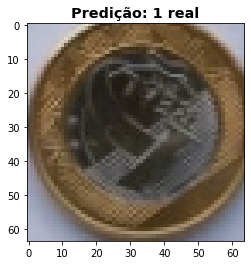

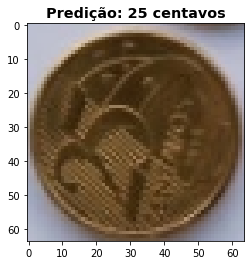

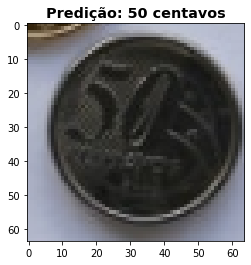

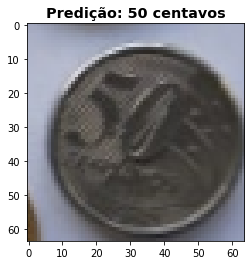

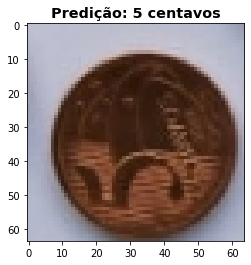

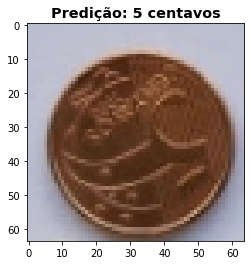

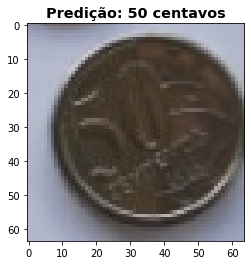

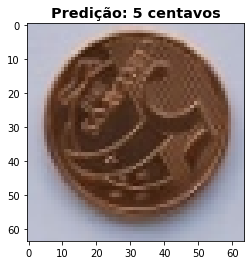

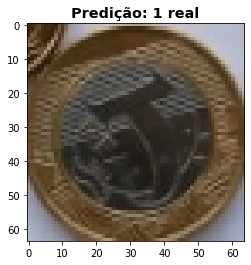

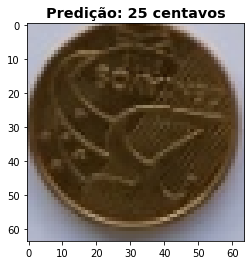

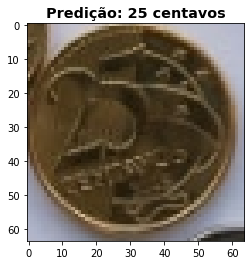

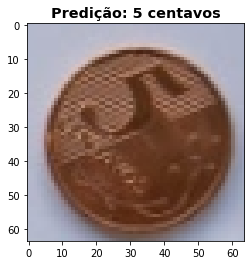

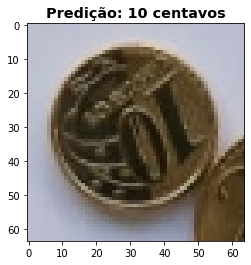

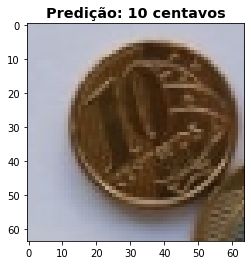

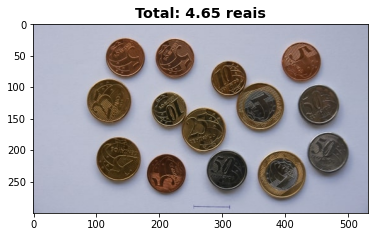

In [14]:
if __name__ == '__main__':
    main()